In [1]:
import numpy as np
import os.path as osp
import os
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
%matplotlib inline 
import sys

src_path = os.path.abspath("../..")
if src_path not in sys.path:
    sys.path.append(src_path)

from dataset.kitti_odometry_dataset import KittiOdometryDataset, KittiOdometryDatasetConfig
from dataset.filters.filter_list import FilterList
from dataset.filters.kitti_gt_mo_filter import KittiGTMovingObjectFilter
from dataset.filters.range_filter import RangeFilter
from dataset.filters.apply_pose import ApplyPose

from functions import hidden_point_removal, project_point_cloud_to_image

In [2]:
DATASET_PATH = os.path.join('/Users/laurenzheidrich/Downloads/','fused_dataset')
SEQUENCE_NUM = 10


config = KittiOdometryDatasetConfig(
    cache=True,
    dataset_path=DATASET_PATH,
    filters=ApplyPose(),
    correct_scan_calibration=True,
)

dataset = KittiOdometryDataset(config, SEQUENCE_NUM)

config_filtered = KittiOdometryDatasetConfig(
    cache=True,
    dataset_path=DATASET_PATH,
    correct_scan_calibration=True,
    filters=FilterList(
        [
            KittiGTMovingObjectFilter(
                os.path.join(
                    DATASET_PATH,
                    "sequences",
                    "%.2d" % SEQUENCE_NUM,
                    "labels",
                )
            ),
            RangeFilter(2.5, 120),
            ApplyPose(),
        ]
    ),
)

dataset_filtered = KittiOdometryDataset(config_filtered, SEQUENCE_NUM)

path_calib = os.path.join(DATASET_PATH,"sequences","%.2d" % SEQUENCE_NUM,"calib.txt")

In [3]:
def get_pcd(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points[:, :3])
    return pcd


points_index = 20
points_cleaned_o3d = get_pcd(dataset_filtered.get_point_cloud(points_index))

image_left_PIL = dataset.get_image("cam2", points_index)
image_right_PIL = dataset.get_image("cam3", points_index)

image_left = cv2.cvtColor(np.array(image_left_PIL), cv2.COLOR_RGB2BGR)
image_right = cv2.cvtColor(np.array(image_right_PIL), cv2.COLOR_RGB2BGR)

In [4]:
### Open Velodyne Point Cloud, RGB Image and Calibration File
points_cleaned_np = np.asarray(points_cleaned_o3d.points)

img = image_left

Number of points in Point Cloud before Hidden Points removal:  120903
Number of points in Point Cloud after Hidden Points removal:  103132
Number of points in 2D projected Point Cloud before FOV filter:  103132
Number of points in 2D projected Point Cloud after FOV filter:  16912
Number of points in 2D projected Point Cloud before FOV filter:  120903
Number of points in 2D projected Point Cloud after FOV filter:  20952


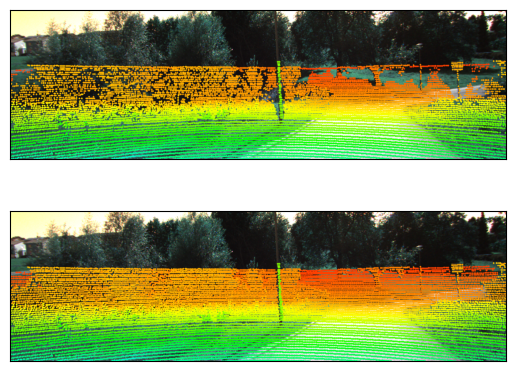

In [5]:
points_cleaned_np_hpr = hidden_point_removal(points_cleaned_np, camera=[0,0,1.73])
overlay_with_removal, inds_with_removal = project_point_cloud_to_image(path_calib, points_cleaned_np_hpr, img)

overlay_without_removal, inds_without_removal = project_point_cloud_to_image(path_calib, points_cleaned_np, img)
	
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

# Display images in subplots
ax1.imshow(overlay_with_removal)
ax2.imshow(overlay_without_removal)

# Hide the axes ticks and labels
ax1.set_xticks([]), ax1.set_yticks([])
ax2.set_xticks([]), ax2.set_yticks([])

plt.show()

In [6]:
points_cleaned_o3d_hpr_fov = o3d.geometry.PointCloud()
points_cleaned_o3d_hpr_fov.points = o3d.utility.Vector3dVector(points_cleaned_np_hpr[inds_with_removal, :])

points_cleaned_o3d_fov = o3d.geometry.PointCloud()
points_cleaned_o3d_fov.points = o3d.utility.Vector3dVector(points_cleaned_np[inds_without_removal, :])